# Disaster Tweets Kaggle Mini-Project

## Step 1: Brief description of the problem and data

#### Goal
The goal of this project is to analyze Twitter data to determine which tweets are about real disasters and which ones are not. Natural language processing (NLP) techniques will be employed to extract features from the tweets, which will then be used for classification.

#### Data
The data provided by Kaggle consists of a training set, a test set, and a sample submission. Kaggle. (n.d.). Kaggle competition: *Natural Language Processing with Disaster Tweets* [Competition Overview]. Retrieved January 8, 2025, from [https://www.kaggle.com/c/nlp-getting-started/overview](https://www.kaggle.com/c/nlp-getting-started/overview).

The structure of the provided data is as follows: 

Files
- **train.csv** - the training set  
- **test.csv** - the test set  
- **sample_submission.csv** - a sample submission file in the correct format  

Columns
- **id** - a unique identifier for each tweet  
- **text** - the text of the tweet  
- **location** - the location the tweet was sent from (may be blank)  
- **keyword** - a particular keyword from the tweet (may be blank)  
- **target** - in `train.csv` only, this denotes whether a tweet is about a real disaster (1) or not (0).

The **training data contains 7613 entries**, the **test data contains 3263 entries**.

#### Natural Language Processing (NLP)
Natural Language Processing (NLP) is a subfield of artificial intelligence. NLP is related to areas like information retrieval and computational linguistics. It uses text data and applies methods like rules, statistics, or machine learning (including deep learning). Common NLP tasks include recognizing speech, classifying text, understanding meaning, and generating natural language [1].


## Step 2: Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data

Imports

In [1]:
# Standard Libraries
import os
import re
import urllib.request
import zipfile
from collections import Counter

# Data Processing
import numpy as np
import pandas as pd

# NLP Libraries
import nltk
from nltk.corpus import stopwords
import string

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning / Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Concatenate, Input, Bidirectional, GlobalAveragePooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import Precision, Recall

# Hyperparameter Tuning
from keras_tuner import HyperModel, RandomSearch

In [2]:
train_df = pd.read_csv('nlp-getting-started/train.csv')
test_df = pd.read_csv('nlp-getting-started/test.csv')

Basic checks

In [3]:
# Check for duplicates
print('Check duplicates in training data')
print(train_df[train_df.duplicated()].count())

print('\nCheck duplicates in test data')
print(test_df[test_df.duplicated()].count())

Check duplicates in training data
id          0
keyword     0
location    0
text        0
target      0
dtype: int64

Check duplicates in test data
id          0
keyword     0
location    0
text        0
dtype: int64


In [4]:
# Check if id is unique
print(train_df['id'].is_unique)
print(test_df['id'].is_unique)

True
True


Training Set

In [5]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
print(f'Training set shape: {train_df.shape}')
print(train_df.info())

Training set shape: (7613, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None


Distributions

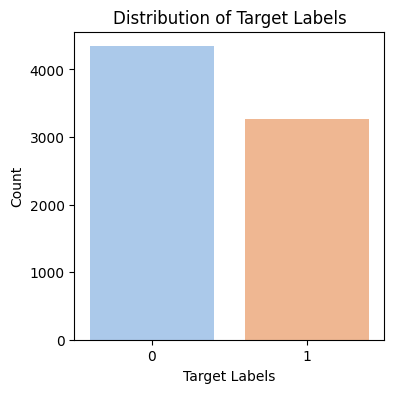

In [7]:
# Distribution of target
plt.figure(figsize=(4, 4))
sns.countplot(data=train_df, x='target', hue='target', palette="pastel", dodge=False, legend=False)
plt.title("Distribution of Target Labels")
plt.xlabel("Target Labels")
plt.ylabel("Count")
plt.show()

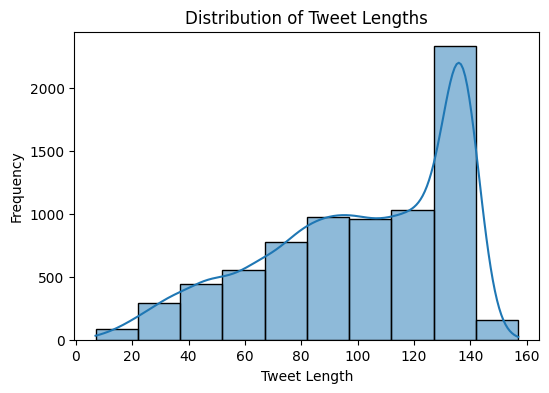

In [8]:
# Tweet length
plt.figure(figsize=(6, 4))
sns.histplot(train_df['text'].str.len(), kde=True, bins=10)
plt.title("Distribution of Tweet Lengths")
plt.xlabel("Tweet Length")
plt.ylabel("Frequency")
plt.show()

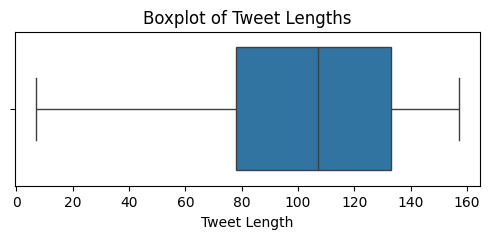

<Figure size 500x300 with 0 Axes>

In [9]:
# Boxplot for text lengths
plt.figure(figsize=(6, 2))
sns.boxplot(x=train_df['text'].str.len())
plt.title("Boxplot of Tweet Lengths")
plt.xlabel("Tweet Length")
plt.figure(figsize=(5, 3))
plt.show()

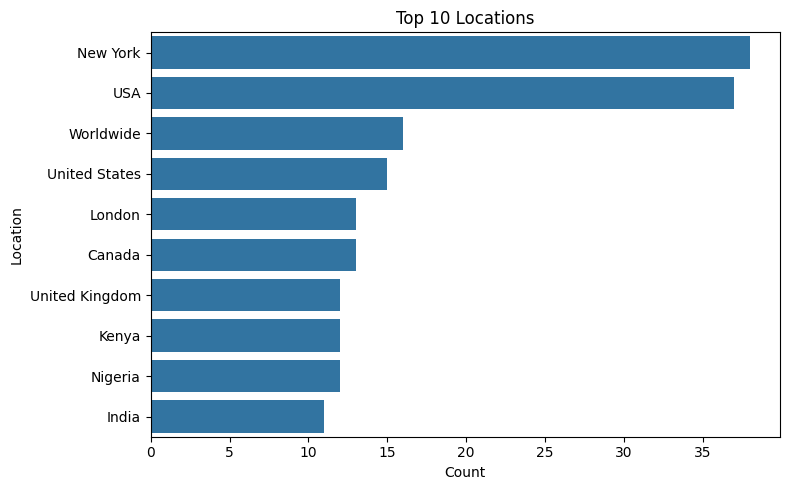

In [10]:
# Top 10 locations
top_locations = (
    test_df["location"]
    .dropna()
    .value_counts()
    .head(10)
    .reset_index()
)

top_locations.columns = ["location", "count"]

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(data=top_locations, x="count", y="location")
plt.title("Top 10 Locations")
plt.xlabel("Count")
plt.ylabel("Location")
plt.tight_layout()
plt.show()

In [11]:
summary = train_df['text'].str.len().agg(['min', 'max', 'mean'])
print(summary)

min       7.000000
max     157.000000
mean    101.037436
Name: text, dtype: float64


Most frequent words

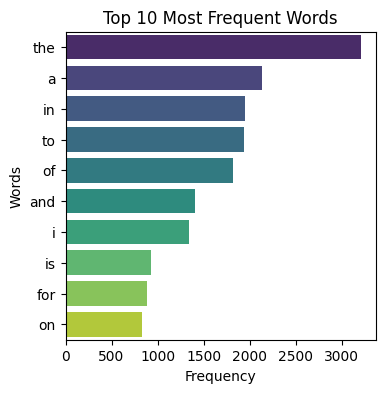

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\guido\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


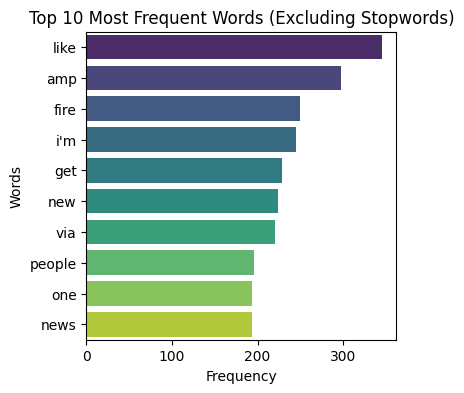

In [12]:
all_words = " ".join(train_df["text"]).lower().split()
word_counts = Counter(all_words)

# top 10 words
most_common_words = word_counts.most_common(10)
words, counts = zip(*most_common_words)

# Plot the top 10 words
plt.figure(figsize=(4, 4))
sns.barplot(x=list(counts), y=list(words), palette="viridis", hue=list(words))
plt.title("Top 10 Most Frequent Words")
plt.xlabel("Frequency")
plt.ylabel("Words")
plt.show()

# Removign stopwords
all_words = " ".join(train_df["text"]).lower().split()

# Remove punctuation and stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

filtered_words = [
    word.strip(string.punctuation)
    for word in all_words
    if word not in stop_words and word.strip(string.punctuation)
]
word_counts = Counter(filtered_words)

# Top 10
most_common_words = word_counts.most_common(10)
words, counts = zip(*most_common_words)

plt.figure(figsize=(4, 4))
sns.barplot(x=list(counts), y=list(words), palette="viridis", hue=list(words))
plt.title("Top 10 Most Frequent Words (Excluding Stopwords)")
plt.xlabel("Frequency")
plt.ylabel("Words")
plt.show()

Test Set

In [13]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [14]:
print(f'Test set shape: {test_df.shape}')
print(test_df.info())

Test set shape: (3263, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB
None


#### EDA Summary
- IDs are unique, and there are no duplicates.  
- Tweet lengths range from 7 to 157 characters.  
- Target classes are not perfectly balanced but are not highly skewed; therefore, no action is required.  
- The analysis of the most frequent words suggests that stopwords should be removed before further processing.

### Plan of analysis
1. Text cleaning: removal of urls, etc., conversion to lowercase, removal of stopwords and punctuation.
2. Tokenization and padding: The text is split into tokens so that it can be processed by the RNN.
3. Word embedding vectorization using GloVe
4. Process keyword and location
5. Training and evaluation.

## Step 3: Model Architecture

### LTSM and bidirectional LTSM
In this project, the performance of two model architectures is tested: 1) a simple LSTM model and 2) a more advanced bidirectional LSTM model.

Model 2 may better capture sequential patterns by using a Bidirectional LSTM and allowing the embedding layer to be fine-tuned. Adding Global Average Pooling simplifies the LSTM outputs, making the model more efficient while keeping important features for classification.

### Word embedding methods
Word embedding methods include Word2Vec, GloVe, FastText, and contextual embeddings like BERT. GloVe is a good choice because it uses word co-occurrence statistics to capture both local and global relationships in text. This results in embeddings that are effective for a wide range of natural language processing tasks.

### Embeddings with GloVe
GloVe is used to create the embeddings. GloVe captures both the global and local context in a corpus by factorizing a word co-occurrence matrix, which counts how often words appear together in a context. This results in dense word vectors, where semantically similar words are located nearby [2].

GloVe is chosen in this project because it provides a good trade-off between complexity and efficiency.

### Model Architecture 1

- **Input Layers:**
  - `input_text`, `input_location`, and `input_keyword`

- **Embedding Layer:**
  - GloVe embeddings, with an embedding matrix (fixed weights)

- **LSTM Layer:**
  - LSTM with 128 units to capture sequential dependencies and Dropout to prevent overfitting.

- **Concatenate Additional Features:**
  - Concatenates the LSTM output with the `location` and `keyword` features.

- **Fully Connected (Dense) Layer:**
  - Dense layer with 64 units and ReLU activation and dropout (0.5) is applied to reduce overfitting.

- **Output Layer:**
  - Dense layer with a single neuron and sigmoid activation for binary classification (disaster vs. non-disaster).

### Model Architecture 2

- **Input Layers:**
  - `input_text`, `input_location`, and `input_keyword`

- **Embedding Layer:**
  - Embedding layer initialized with a pre-trained embedding matrix (trainable).

- **Bidirectional LSTM Layer:**
  - A Bidirectional LSTM with 128 units, including a dropout rate of 0.2 and recurrent dropout rate of 0.2, capturing sequential dependencies in both forward and backward directions. Outputs a sequence.

- **Pooling Layer:**
  - Global Average Pooling layer to summarize the sequential LSTM output.

- **Concatenate Additional Features:**
  - Concatenates the pooled LSTM output with the `location` and `keyword` features.

- **Fully Connected (Dense) Layer:**
  - Dense layer with 128 units and ReLU activation, followed by a dropout layer with a rate of 0.5 to prevent overfitting.

- **Output Layer:**
  - Dense layer with a single neuron and sigmoid activation for binary classification (disaster vs. non-disaster).

## Step 4: Results and Analysis

Run hyperparameter tuning, try different architectures for comparison, apply techniques to improve training or performance, and discuss what helped.

Includes results with tables and figures. There is an analysis of why or why not something worked well, troubleshooting, and a hyperparameter optimization procedure summary.

The following steps are carried out in this section:  
- Create embeddings using GloVe 6B  
- Train Model 1 and evaluate its performance  
- Perform hyperparameter tuning for Model 1  
- Train Model 2 and evaluate its performance  
- Generate a submission file using the test data.  

Download GloVe Embeddings 

In [15]:
url = 'https://nlp.stanford.edu/data/glove.6B.zip'
output_path = 'glove.6B.zip'

if not os.path.exists(output_path):
    print("Downloading GloVe embeddings...")
    urllib.request.urlretrieve(url, output_path)
else:
    print("GloVe embeddings file already exists.")

if not os.path.exists('glove.6B'):
    with zipfile.ZipFile(output_path, 'r') as zip_ref:
        zip_ref.extractall()
else:
    print("GloVe embeddings already extracted.")

# Load the GloVe embeddings
def load_glove_embeddings(glove_file_path):
    embeddings_index = {}
    with open(glove_file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

GloVe embeddings file already exists.


In [16]:
# Load the GloVe embeddings
glove_file_path = 'glove.6B.100d.txt'
glove_embeddings = load_glove_embeddings(glove_file_path)

Text processing

In [17]:
# Remove unnecessary characters and stopwords

def clean_text(text):
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'[^A-Za-z\s]', '', text)
    text = text.lower()
    text = ' '.join([word for word in text.split() if word not in stopwords.words('english')])
    return text

train_df['cleaned_text'] = train_df['text'].apply(clean_text)

In [18]:
train_df.head()

,id,keyword,location,text,target,cleaned_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,deeds reason earthquake may allah forgive us
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,residents asked shelter place notified officer...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,people receive wildfires evacuation orders cal...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo ruby alaska smoke wildfires pou...


Tokenization and Padding, embeddings, location and keyword processing

In [19]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_df['cleaned_text'])
X_text = tokenizer.texts_to_sequences(train_df['cleaned_text'])
X_text = pad_sequences(X_text, maxlen=100)

# Embedding Matrix
embedding_dim = 100
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, embedding_dim))
for word, i in tokenizer.word_index.items():
    if word in glove_embeddings:
        embedding_matrix[i] = glove_embeddings[word]

# Location and Keyword processing
X_location = train_df['location'].fillna('').apply(lambda x: 1 if x else 0).values
X_keyword = train_df['keyword'].fillna('').apply(lambda x: 1 if x else 0).values

### Model architecture 1

In [20]:
input_text = Input(shape=(100,))
input_location = Input(shape=(1,))
input_keyword = Input(shape=(1,))

# Embedding Layer
embedding_layer = Embedding(input_dim=len(tokenizer.word_index) + 1,
                            output_dim=embedding_dim,
                            weights=[embedding_matrix],
                            trainable=False)(input_text)

# LSTM Layer
x = LSTM(units=128, dropout=0.2, recurrent_dropout=0.2)(embedding_layer)

# Concatenate Additional Features
x = Concatenate()([x, input_location, input_keyword])

# Fully Connected Layer
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)

# Output Layer
output = Dense(1, activation='sigmoid')(x)

# Compile
model = Model(inputs=[input_text, input_location, input_keyword], outputs=output)

model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
)

Model training and evaluation

In [21]:
y = train_df['target'].values

X_train_text, X_val_text, X_train_loc, X_val_loc, X_train_kw, X_val_kw, y_train, y_val = train_test_split(
    X_text, X_location, X_keyword, y, test_size=0.2, random_state=42)

model.fit([X_train_text, X_train_loc, X_train_kw], y_train, epochs=5, batch_size=32, validation_data=([X_val_text, X_val_loc, X_val_kw], y_val))

accuracy = model.evaluate([X_val_text, X_val_loc, X_val_kw], y_val)
print(f'Validation Accuracy: {accuracy[1]*100:.2f}%')

Epoch 1/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 18s 68ms/step - accuracy: 0.7292 - loss: 0.5505 - precision: 0.7284 - recall: 0.5990 - val_accuracy: 0.8129 - val_loss: 0.4323 - val_precision: 0.8358 - val_recall: 0.6980
Epoch 2/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 13s 69ms/step - accuracy: 0.7905 - loss: 0.4573 - precision: 0.8032 - recall: 0.6690 - val_accuracy: 0.8129 - val_loss: 0.4422 - val_precision: 0.7964 - val_recall: 0.7535
Epoch 3/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 11s 59ms/step - accuracy: 0.8035 - loss: 0.4477 - precision: 0.8222 - recall: 0.6908 - val_accuracy: 0.8122 - val_loss: 0.4324 - val_precision: 0.8010 - val_recall: 0.7442
Epoch 4/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 13s 69ms/step - accuracy: 0.8146 - loss: 0.4170 - precision: 0.8269 - recall: 0.7163 - val_accuracy: 0.8070 - val_loss: 0.4348 - val_precision: 0.8330 - val_recall: 0.6841
Epoch 5/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 13s 68ms/step - accuracy: 0.8088 - loss: 0.4243 - precision: 0.8370 - recall: 0.6913 - val_accuracy: 0.8109 - val_los

### Model architecture 1 with hyperparameter tuning

In [22]:
# HyperModel class for Keras Tuner
class DisasterTweetModel(HyperModel):
    def build(self, hp):
        input_text = Input(shape=(100,))
        input_location = Input(shape=(1,))
        input_keyword = Input(shape=(1,))

        embedding_layer = Embedding(input_dim=len(tokenizer.word_index) + 1,
                                    output_dim=embedding_dim,
                                    weights=[embedding_matrix],
                                    trainable=False)(input_text)

        x = LSTM(units=hp.Int('lstm_units', min_value=64, max_value=256, step=64),
                 dropout=hp.Float('lstm_dropout', min_value=0.2, max_value=0.5, step=0.1),
                 recurrent_dropout=hp.Float('lstm_recurrent_dropout', min_value=0.2, max_value=0.5, step=0.1))(embedding_layer)

        x = Concatenate()([x, input_location, input_keyword])

        x = Dense(hp.Int('dense_units', min_value=32, max_value=128, step=32), activation='relu')(x)
        x = Dropout(0.5)(x)

        output = Dense(1, activation='sigmoid')(x)

        model = Model(inputs=[input_text, input_location, input_keyword], outputs=output)
        model.compile(loss='binary_crossentropy',
                      optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='LOG')),
                      metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])
        
        return model

tuner = RandomSearch(
    DisasterTweetModel(),
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    project_name='disaster_tweet_tuning'
)

# Perform search, get best model and evaluate
tuner.search([X_train_text, X_train_loc, X_train_kw], y_train, epochs=5, batch_size=32, validation_data=([X_val_text, X_val_loc, X_val_kw], y_val))

best_model = tuner.get_best_models(num_models=1)[0]

best_model.compile(loss='binary_crossentropy',
                   optimizer=Adam(learning_rate=1e-4),
                   metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])

accuracy = best_model.evaluate([X_val_text, X_val_loc, X_val_kw], y_val)
print(f'Best model validation accuracy: {accuracy[1]*100:.2f}%')


Trial 10 Complete [00h 02m 12s]
val_accuracy: 0.813525915145874

Best val_accuracy So Far: 0.8194352984428406
Total elapsed time: 00h 13m 11s


c:\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 16 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.8118 - loss: 0.4584 - precision: 0.8294 - recall: 0.7094
Best model validation accuracy: 81.94%


Create submission data and save

In [23]:
# Clean, tokenize, and process
test_df['cleaned_text'] = test_df['text'].apply(clean_text)

X_test_text = tokenizer.texts_to_sequences(test_df['cleaned_text'])
X_test_text = pad_sequences(X_test_text, maxlen=100)

X_test_location = test_df['location'].fillna('').apply(lambda x: 1 if x else 0).values
X_test_keyword = test_df['keyword'].fillna('').apply(lambda x: 1 if x else 0).values

predictions = best_model.predict([X_test_text, X_test_location, X_test_keyword])

predictions = (predictions > 0.5).astype(int)

# Create file for submission
submission = pd.DataFrame({
    'id': test_df['id'],
    'target': predictions.flatten()
})

# Save
submission.to_csv('submission-1.csv', index=False)

102/102 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step


### Model architecture 2

In [24]:
# Model Inputs
input_text = Input(shape=(100,))
input_location = Input(shape=(1,))
input_keyword = Input(shape=(1,))

# Embedding Layer
embedding_layer = Embedding(input_dim=len(tokenizer.word_index) + 1,
                            output_dim=embedding_dim,
                            weights=[embedding_matrix],
                            trainable=True)(input_text)

# Bidirectional LSTM Layer
x = Bidirectional(LSTM(units=128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))(embedding_layer)

# Pooling Layer (Global Average Pooling)
x = GlobalAveragePooling1D()(x)

# Concatenate Additional Features
x = Concatenate()([x, input_location, input_keyword])

# Fully Connected Layer
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)

# Output Layer
output = Dense(1, activation='sigmoid')(x)

# Compile Model
model = Model(inputs=[input_text, input_location, input_keyword], outputs=output)
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=1e-4), 
              metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])

# Train the Model
history = model.fit(
    [X_train_text, X_train_loc, X_train_kw], y_train,
    epochs=10,
    batch_size=32,
    validation_data=([X_val_text, X_val_loc, X_val_kw], y_val),
    verbose=2
)

# Evaluate the Model
eval_metrics = model.evaluate([X_val_text, X_val_loc, X_val_kw], y_val)
loss, accuracy, precision, recall = eval_metrics

print(f'Validation Loss: {loss}')
print(f'Validation Accuracy: {accuracy}')
print(f'Validation Precision: {precision}')
print(f'Validation Recall: {recall}')


Epoch 1/10
191/191 - 25s - 131ms/step - accuracy: 0.6437 - loss: 0.6285 - precision: 0.7251 - recall: 0.2777 - val_accuracy: 0.7866 - val_loss: 0.4884 - val_precision: 0.7492 - val_recall: 0.7504
Epoch 2/10
191/191 - 19s - 101ms/step - accuracy: 0.7727 - loss: 0.5169 - precision: 0.7824 - recall: 0.6541 - val_accuracy: 0.7905 - val_loss: 0.4780 - val_precision: 0.9064 - val_recall: 0.5670
Epoch 3/10
191/191 - 18s - 96ms/step - accuracy: 0.7860 - loss: 0.4931 - precision: 0.8184 - recall: 0.6465 - val_accuracy: 0.8096 - val_loss: 0.4470 - val_precision: 0.8432 - val_recall: 0.6795
Epoch 4/10
191/191 - 17s - 90ms/step - accuracy: 0.7906 - loss: 0.4829 - precision: 0.8085 - recall: 0.6732 - val_accuracy: 0.8181 - val_loss: 0.4395 - val_precision: 0.8394 - val_recall: 0.7088
Epoch 5/10
191/191 - 17s - 88ms/step - accuracy: 0.7964 - loss: 0.4639 - precision: 0.8272 - recall: 0.6663 - val_accuracy: 0.8194 - val_loss: 0.4371 - val_precision: 0.8667 - val_recall: 0.6810
Epoch 6/10
191/191 - 20

Create submission data and save

In [25]:
predictions = model.predict([X_test_text, X_test_location, X_test_keyword])
predictions = (predictions > 0.5).astype(int)

# Create file for submission
submission = pd.DataFrame({
    'id': test_df['id'],
    'target': predictions.flatten()
})

# Save
submission.to_csv('submission-2.csv', index=False)

102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step


### Summary of Results and discussion
The following table summarizes the results:

| Metric          | Model 1       | Model 2       |
|-----------------|---------------|---------------|
| Accuracy        | 0.8088        | 0.8268        |
| Loss            | 0.4243        | 0.4179        |
| Precision       | 0.8370        | 0.8499        |
| Recall          | 0.6913        | 0.7258        |
| Validation Accuracy | 0.8109    | 0.8227        |
| Validation Loss | 0.4286        | 0.4315        |
| Validation Precision | 0.8336    | 0.8132        |
| Validation Recall | 0.6949       | 0.7581        |

Both models achieved good results in predicting whether a Tweet was associated with a real diseaster or not. Hyperparameter tuning slightly imporved the results for model 1. The more complex structure of model 2 led to minor improvements compared to model 1 in terms of accuracy, precision and recall.

## Step 5: Conclusion 

Both model types tested in this project performed satisfactorily in classifying the tweets.

Generating the embeddings and performing feature engineering were important aspects of the project. GloVe was chosen to generate the embeddings because it combines the advantages of context-based methods (like Word2Vec) and global matrix factorization methods.

Two model architectures were tested: a simple LSTM model and a bidirectional LSTM model. Hyperparameter tuning was performed for the first model, but this was not repeated for the second model, as it only led to minor improvements. However, the more complex architecture of Model 2 resulted in a noticeable improvement over Model 1.

To further improve the approach in the future, several strategies could be attempted:
1) The information from the `location` and `keyword` features could be utilized by processing them in terms of similarity and extracting features for the model;
2) Hyperparameter tuning could be extended; and
3) Different model architectures could be explored.

## References
[1] Wikipedia contributors. (n.d.). *Natural language processing*. Wikipedia. Retrieved January 9, 2025, from https://en.wikipedia.org/wiki/Natural_language_processing

[2] Pennington, J., Socher, R., & Manning, C. D. (n.d.). *GloVe: Global Vectors for Word Representation*. Retrieved January 9, 2025, from [https://nlp.stanford.edu/projects/glove/](https://nlp.stanford.edu/projects/glove/)